In [1]:
%config IPCompleter.greedy = True
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn

pd.set_option('mode.chained_assignment', None)
sn.set(rc={'figure.figsize':(9,9)})
sn.set(font_scale=1.4)

# Clustering Distribution models - Gaussian Mixture Models

The `sklearn.mixture` package contains Gaussian
Mixture Models (diagonal, spherical, tied and full covariance matrices
supported), where they allow sampling and learning the mixture (or linear superposition of) multiple multivariate gaussians distributios from the data.

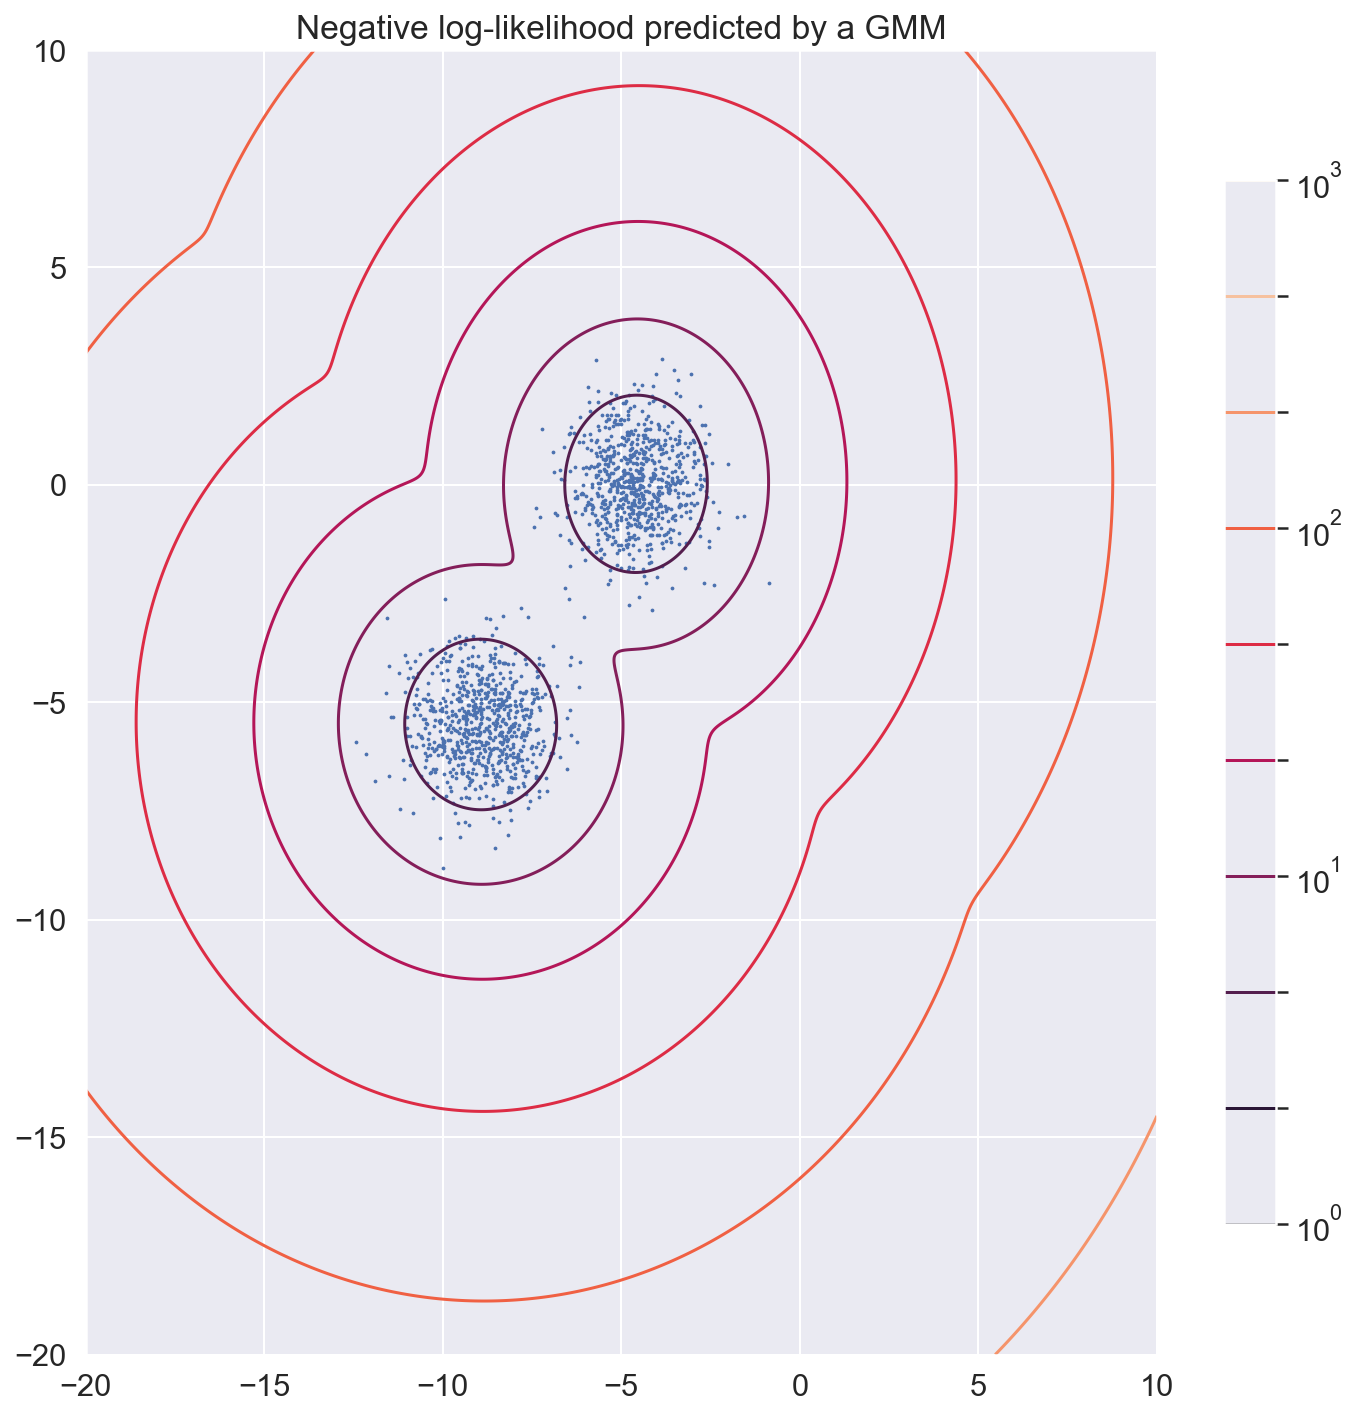

In [2]:
from sklearn.datasets import make_blobs
from sklearn import mixture
from matplotlib.colors import LogNorm

def plot_gaussian_mixture_models(k=2):
    n_samples = 1500
    random_state = 170

    X_train, y = make_blobs(n_samples=n_samples,
                      random_state=random_state, centers=k )
    clf = mixture.GaussianMixture(n_components=k , covariance_type='full')
    clf.fit(X_train)

    x = np.linspace(-20., 10., 1000)
    y = np.linspace(-20., 10., 1000)
    X, Y = np.meshgrid(x, y)
    XX = np.array([X.ravel(), Y.ravel()]).T
    Z = -clf.score_samples(XX)
    Z = Z.reshape(X.shape)

    plt.figure(figsize=(12, 12))
    CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                     levels=np.logspace(0, 3, 10))
    CB = plt.colorbar(CS, shrink=0.8, extend='both')
    plt.scatter(X_train[:, 0], X_train[:, 1], 0.8)

    plt.title('Negative log-likelihood predicted by a GMM')
    plt.axis('tight')
    plt.show()

plot_gaussian_mixture_models(k=2)

We can also calculate the density estimation of a mixture of two gaussians with different centers and covariance matricies.

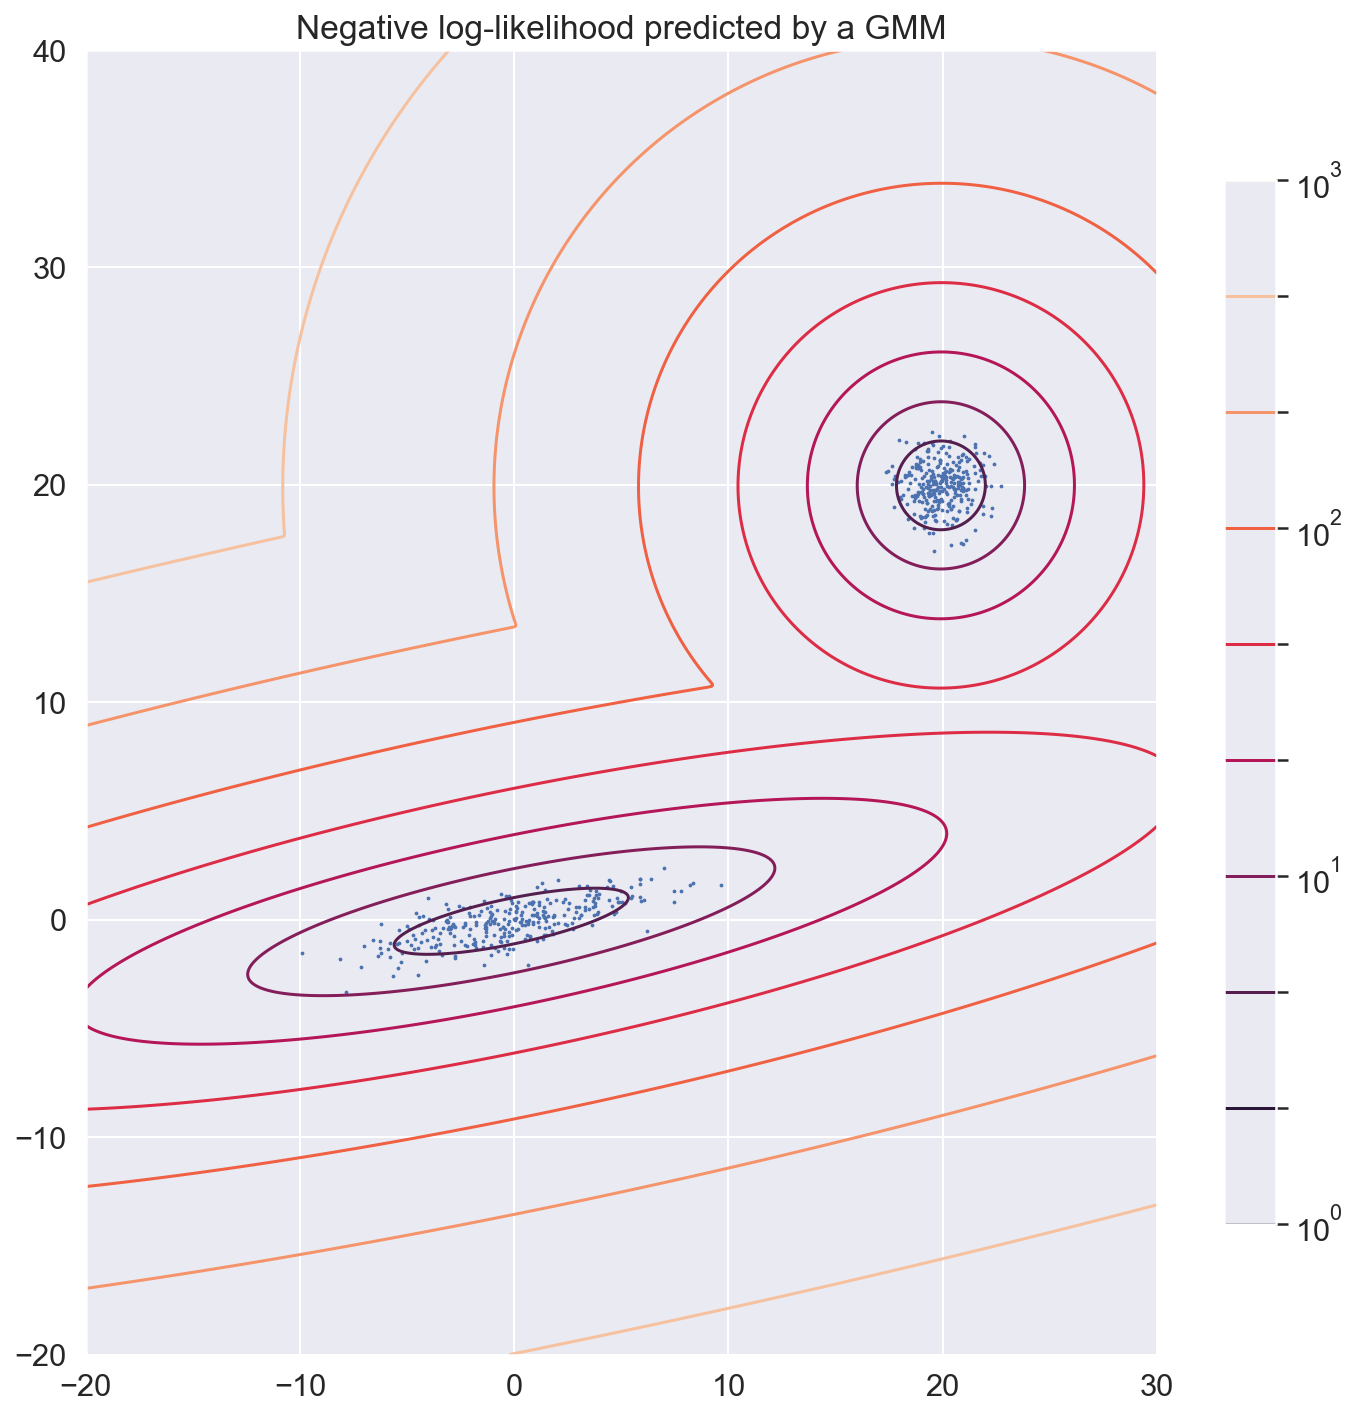

In [3]:
from matplotlib.colors import LogNorm
from sklearn import mixture

n_samples = 300

# generate random sample, two components
np.random.seed(0)

# generate spherical data centered on (20, 20)
shifted_gaussian = np.random.randn(n_samples, 2) + np.array([20, 20])

# generate zero centered stretched Gaussian data
C = np.array([[0., -0.7], [3.5, .7]])
stretched_gaussian = np.dot(np.random.randn(n_samples, 2), C)

# concatenate the two datasets into the final training set
X_train = np.vstack([shifted_gaussian, stretched_gaussian])

# fit a Gaussian Mixture Model with two components
clf = mixture.GaussianMixture(n_components=2, covariance_type='full')
clf.fit(X_train)

# display predicted scores by the model as a contour plot
x = np.linspace(-20., 30.,1000)
y = np.linspace(-20., 40.,1000)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -clf.score_samples(XX)
Z = Z.reshape(X.shape)

plt.figure(figsize=(12, 12))
CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                 levels=np.logspace(0, 3, 10))
CB = plt.colorbar(CS, shrink=0.8, extend='both')
plt.scatter(X_train[:, 0], X_train[:, 1], .8)

plt.title('Negative log-likelihood predicted by a GMM')
plt.axis('tight')
plt.show()

A Gaussian mixture model is a probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters.

### Theory

In a multivariate distribution one may model a vector of parameters using a Gaussian mixture model prior distribution on the vector of estimates given by

$$ p(\boldsymbol{\theta}) = \sum_{i=1}^K\phi_i \mathcal{N}(\boldsymbol{\mu_i,\Sigma_i}) $$

Where the $i^{th}$ vector component is characterized by normal distributions with weights $\phi_i$, means $\boldsymbol{\mu_i}$ and covariance matrices $\boldsymbol{\Sigma_i}$. To incorporate this prior into a Bayesian estimation, the prior is multiplied with the known distribution $p(\boldsymbol{x | \theta})$ of the data $\boldsymbol{x}$ conditioned on the parameters $\boldsymbol{\theta}$ to be estimated.  With this formulation, the *posterior distribution* $p(\boldsymbol{\theta | x})$ is *also* a Gaussian mixture model of the form 

$$ p(\boldsymbol{\theta | x}) = \sum_{i=1}^K\tilde{\phi_i} \mathcal{N}(\boldsymbol{\tilde{\mu_i},\tilde{\Sigma_i}}) $$

with new parameters $\tilde{\phi_i}, \boldsymbol{\tilde{\mu_i}}$ and $\boldsymbol{\tilde{\Sigma_i}}$ that are updated using the *Expectation-maximization algorithm*.

Scikit-learn implements different classes to estimate Gaussian mixture models, that correspond to different estimation strategies, detailed below.

## Gaussian Mixture


The `GaussianMixture` object implements the `expectation-maximization` (EM) algorithm for fitting mixture-of Gaussian models. It can also draw confidence ellipsoids for multivariate models, and compute
the Bayesian Information Criterion (BIC) to assess the number of clusters in
the data. A `GaussianMixture.fit` method
is provided that learns a Gaussian Mixture Model from train data. Given
test data, it can assign to each sample the Gaussian it mostly probably
belong to using the `GaussianMixture.predict` method.

The `GaussianMixture` comes with
different options to constrain the covariance of the difference classes
estimated:

|Covariance Type|Description|
|---------------|-----------|
|`full`| Each gaussian has its own general covariance matrix |
|`tied`| All gaussians share the same general covariance matrix |
|`diag`| Each gaussians has its own diagonal covariance matrix |
|`spherical`| Each gaussian has its own single variance |

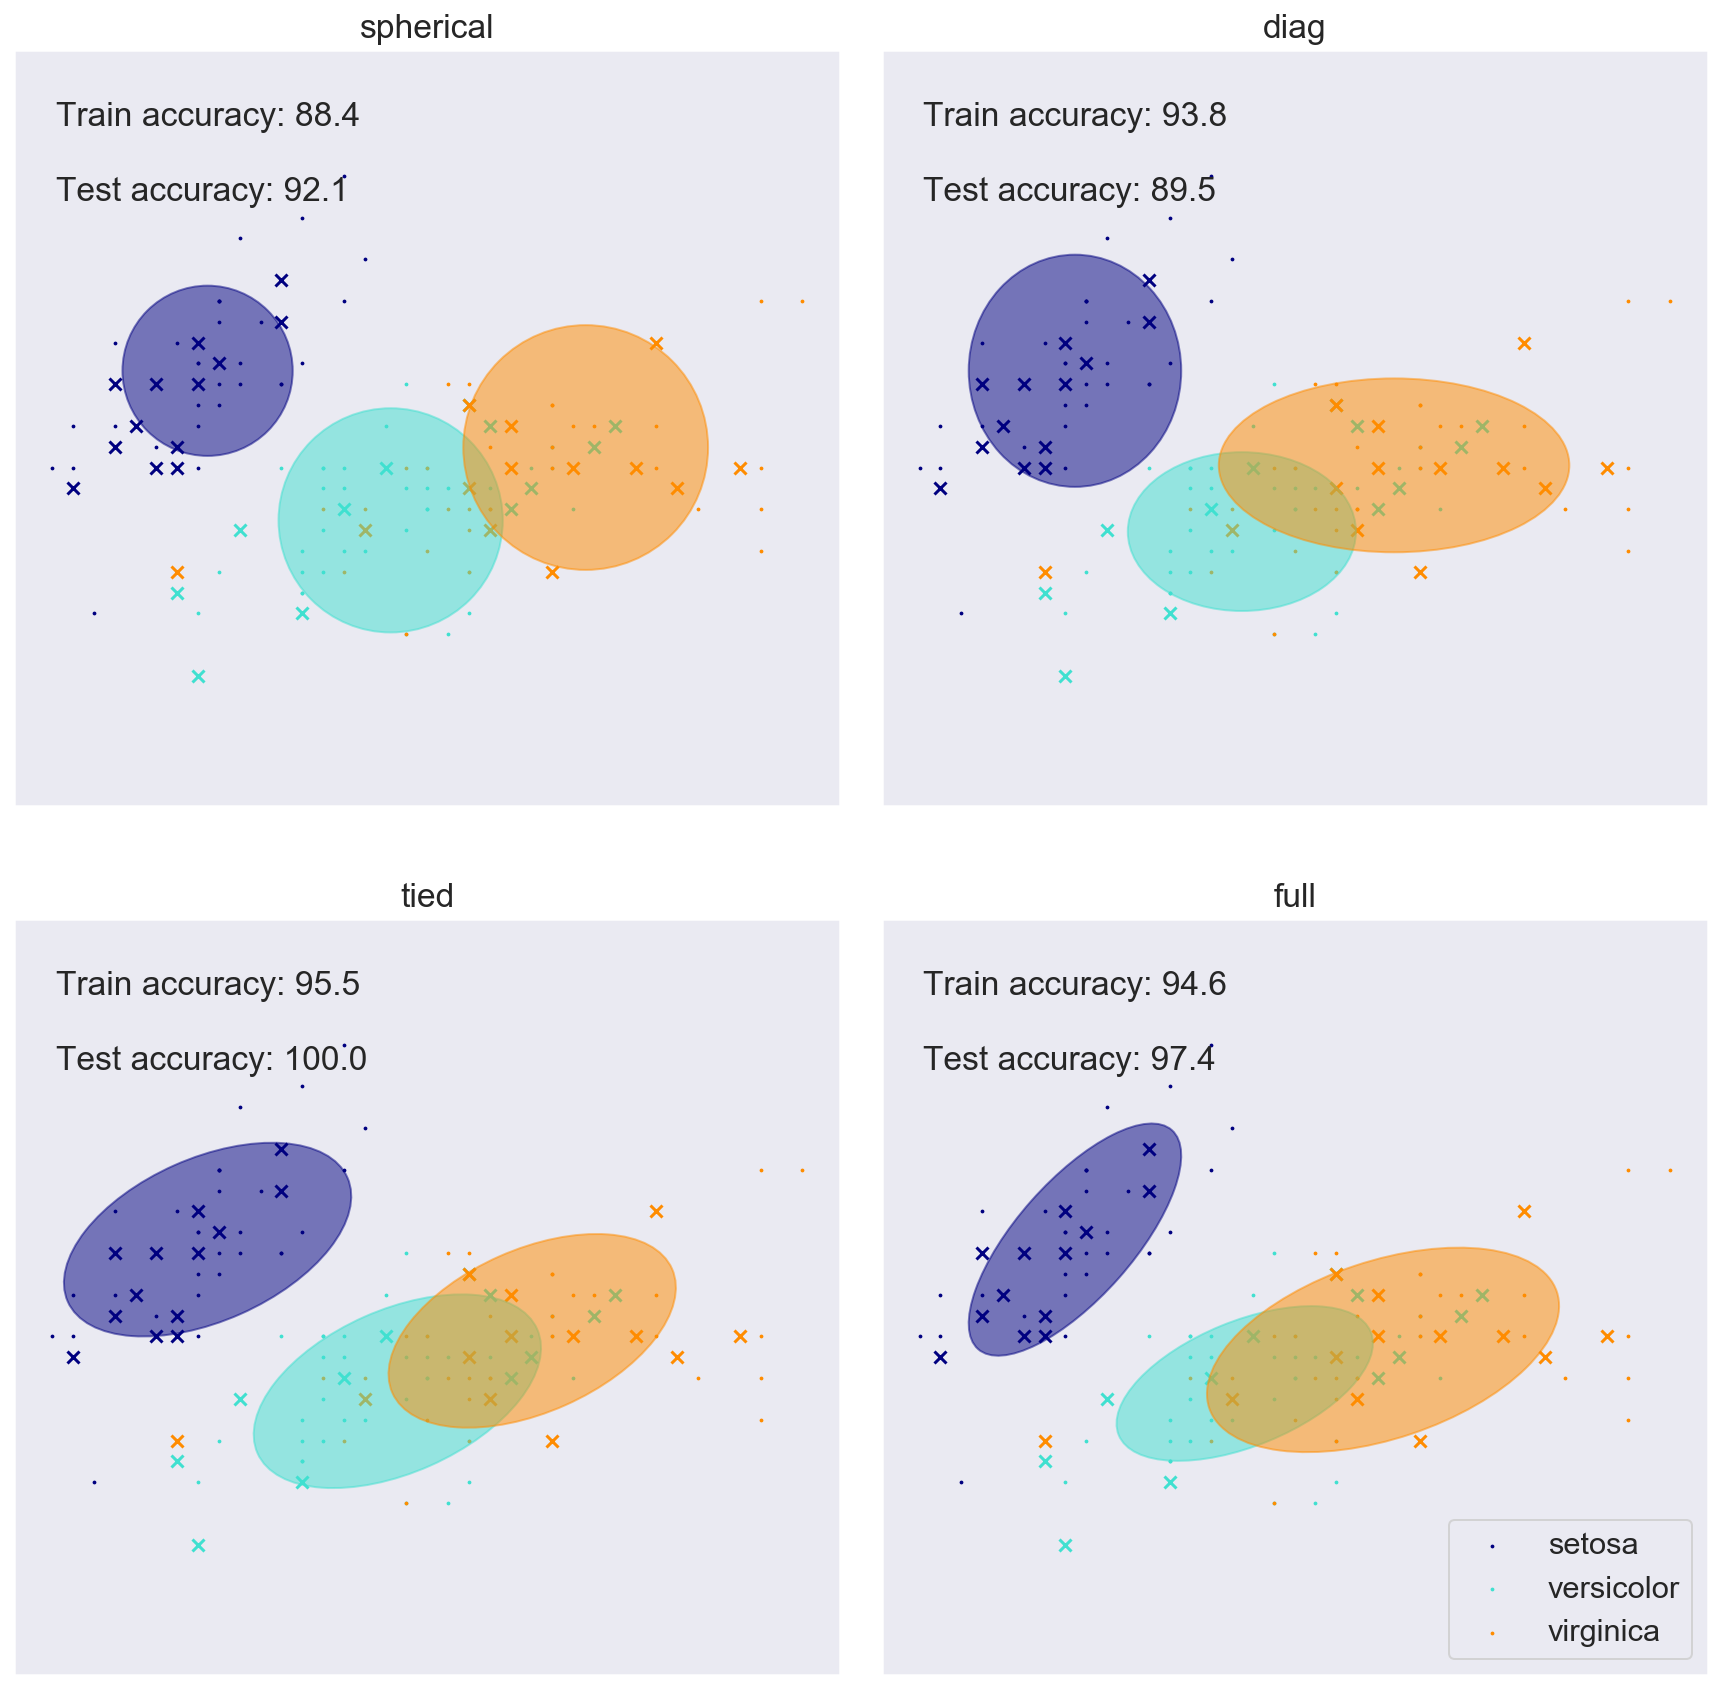

In [4]:
import matplotlib as mpl
from sklearn import datasets
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import StratifiedKFold

colors = ['navy', 'turquoise', 'darkorange']

def make_ellipses(gmm, ax):
    for n, color in enumerate(colors):
        if gmm.covariance_type == 'full':
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == 'tied':
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == 'diag':
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == 'spherical':
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],
                                  180 + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        ax.set_aspect('equal', 'datalim')

iris = datasets.load_iris()

# Break up the dataset into non-overlapping training (75%) and testing
# (25%) sets.
skf = StratifiedKFold(n_splits=4)
# Only take the first fold.
train_index, test_index = next(iter(skf.split(iris.data, iris.target)))


X_train = iris.data[train_index]
y_train = iris.target[train_index]
X_test = iris.data[test_index]
y_test = iris.target[test_index]

n_classes = len(np.unique(y_train))

# Try GMMs using different types of covariances.
estimators = {cov_type: GaussianMixture(n_components=n_classes,
              covariance_type=cov_type, max_iter=20, random_state=0)
              for cov_type in ['spherical', 'diag', 'tied', 'full']}

n_estimators = len(estimators)

scaling = 2
plt.figure(figsize=(scaling * 3 * n_estimators // 2, scaling * 6))
plt.subplots_adjust(bottom=.01, top=0.95, hspace=.15, wspace=.05,
                    left=.01, right=.99)


for index, (name, estimator) in enumerate(estimators.items()):
    # Since we have class labels for the training data, we can
    # initialize the GMM parameters in a supervised manner.
    estimator.means_init = np.array([X_train[y_train == i].mean(axis=0)
                                    for i in range(n_classes)])

    # Train the other parameters using the EM algorithm.
    estimator.fit(X_train)

    h = plt.subplot(2, n_estimators // 2, index + 1)
    make_ellipses(estimator, h)

    for n, color in enumerate(colors):
        data = iris.data[iris.target == n]
        plt.scatter(data[:, 0], data[:, 1], s=0.8, color=color,
                    label=iris.target_names[n])
    # Plot the test data with crosses
    for n, color in enumerate(colors):
        data = X_test[y_test == n]
        plt.scatter(data[:, 0], data[:, 1], marker='x', color=color)

    y_train_pred = estimator.predict(X_train)
    train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel()) * 100
    plt.text(0.05, 0.9, 'Train accuracy: %.1f' % train_accuracy,
             transform=h.transAxes)

    y_test_pred = estimator.predict(X_test)
    test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel()) * 100
    plt.text(0.05, 0.8, 'Test accuracy: %.1f' % test_accuracy,
             transform=h.transAxes)

    plt.xticks(())
    plt.yticks(())
    plt.title(name)

plt.legend(scatterpoints=1, loc='lower right')


plt.show()

`GaussianMixture` model:

**Advantages**
* Fastest algorithm among the learning mixture models.
* Agnostic to priors, as using EM it only maximises the likelihood, it will not bias the mean towards zero, or bias the cluster sizes to have specific structures that might or might not apply.

**Disadvantages**
* Need sufficient points per mixture, else estimating the covariance becomes difficult, and the algorithm is know to diverge and find solutions with infinite likelihood unless you regularise the covariances artificially.
* Need to select the number of gaussians (components), however it is possible to find a suitable number by using an information theoreritical criteria (Elbow method) in the absence of external cues.

### Selecting the number of components in a classical Gaussian Mixture Model

The BIC criterion can be used to select the number of components in a
Gaussian Mixture in an efficient way. In theory, it recovers the true
number of components only in the asymptotic regime (i.e. if much data is
available and assuming that the data was actually generated i.i.d. from
a mixture of Gaussian distribution). Note that using a
`Variational Bayesian Gaussian mixture ` avoids the specification of the number of components for a
Gaussian mixture model. This uses the *ELBOW* method of the criterion.

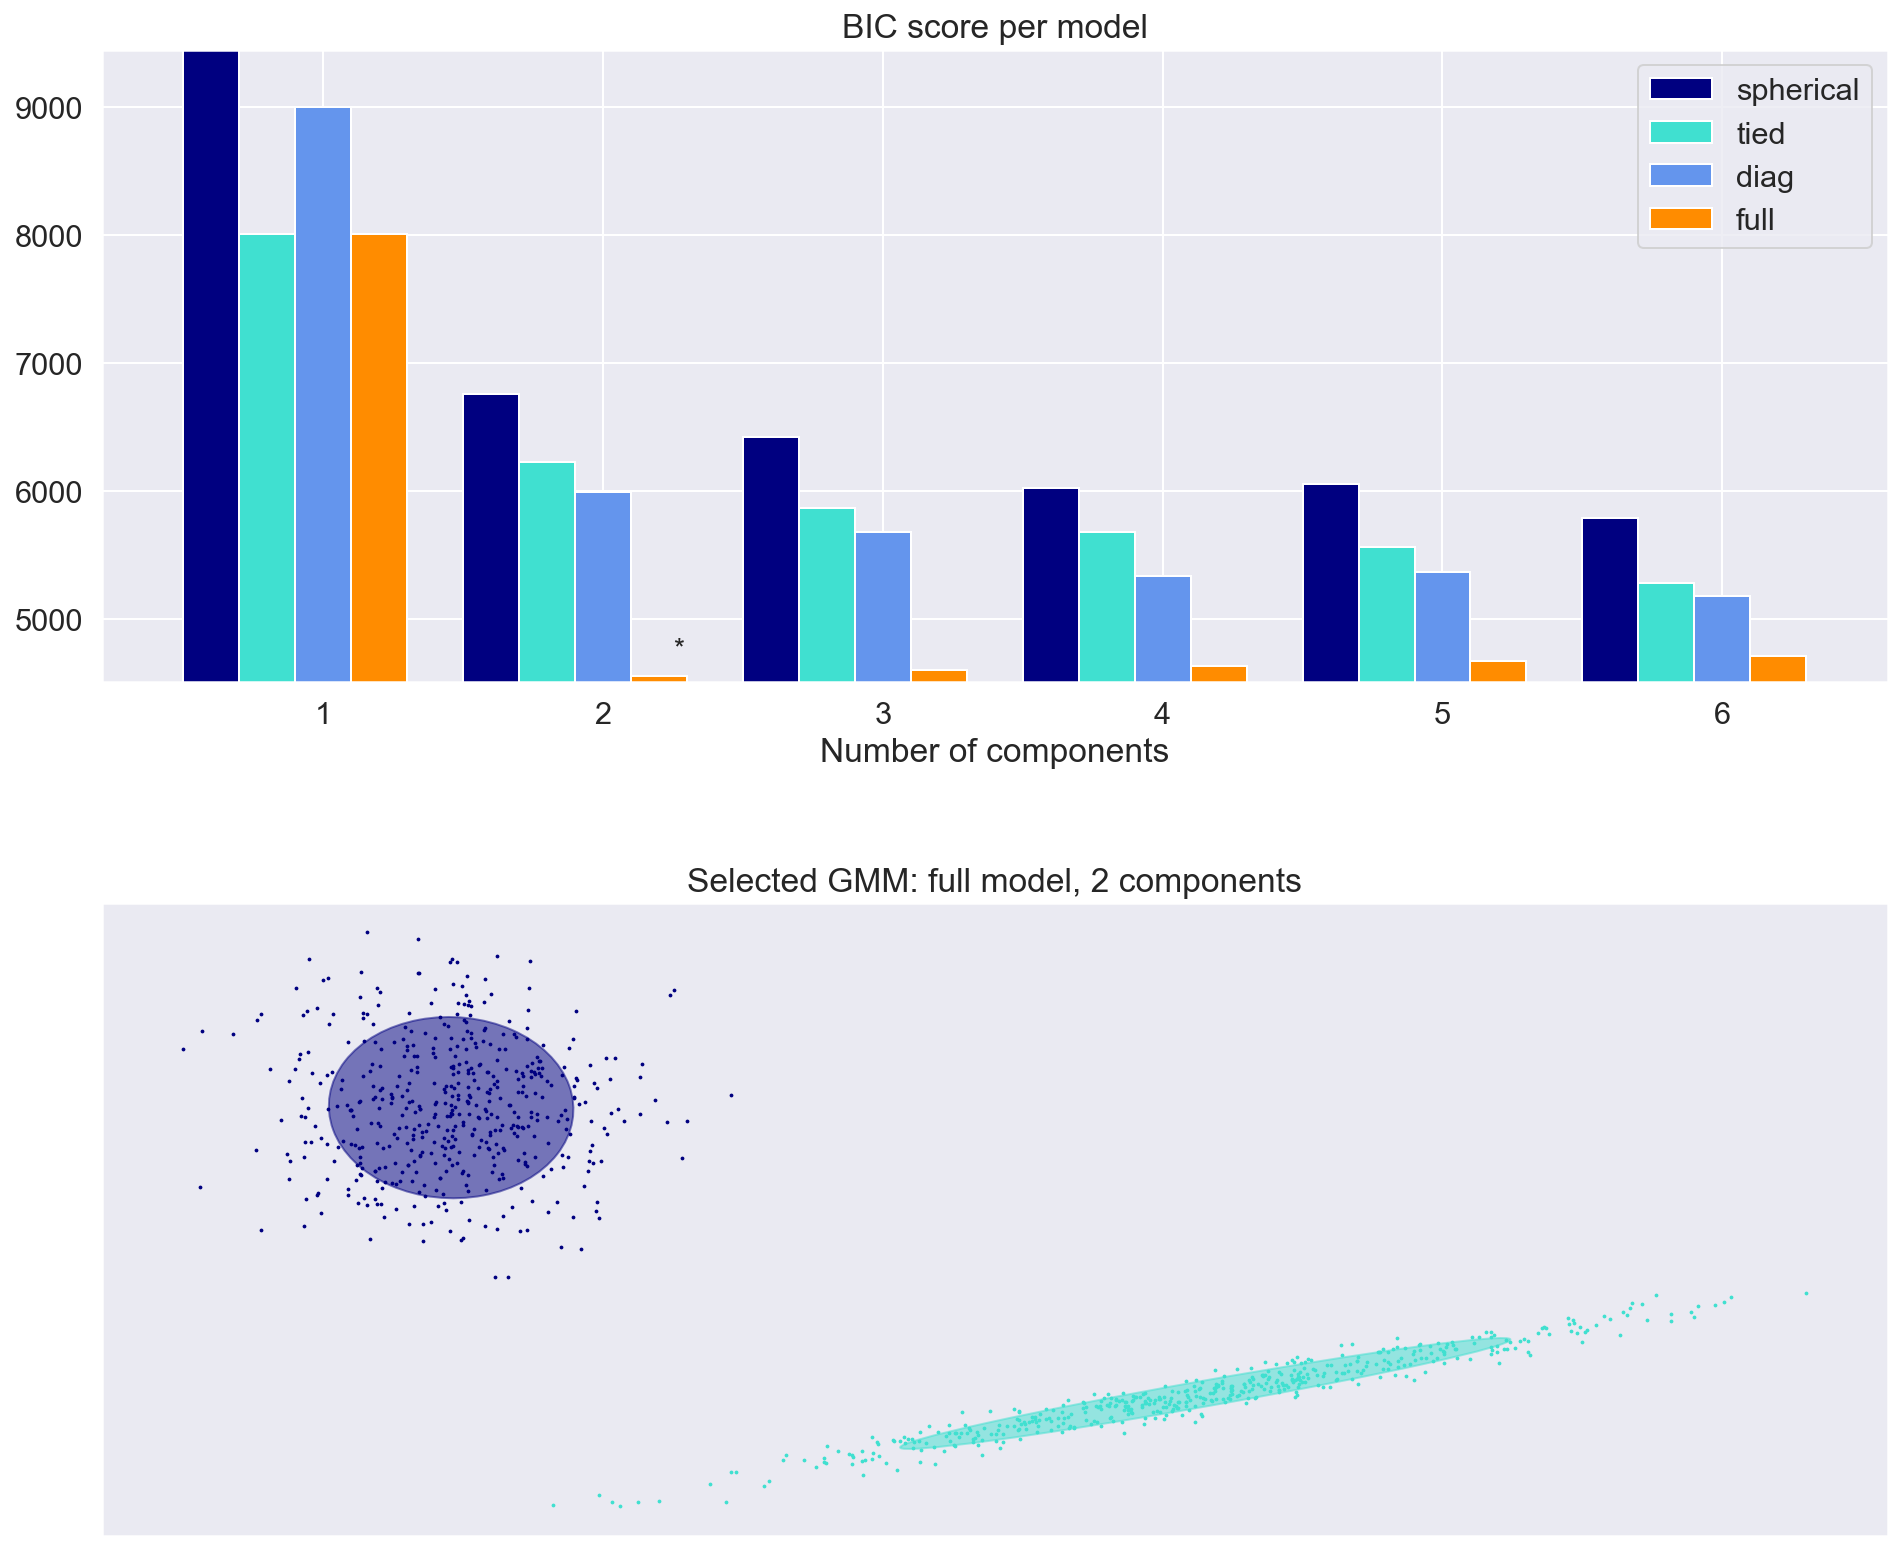

In [5]:
import itertools
from scipy import linalg
import matplotlib as mpl
from sklearn import mixture

# Number of samples per component
n_samples = 500

# Generate random sample, two components
np.random.seed(0)
C = np.array([[0., -0.1], [1.7, .4]])
X = np.r_[np.dot(np.random.randn(n_samples, 2), C),
          .7 * np.random.randn(n_samples, 2) + np.array([-6, 3])]

lowest_bic = np.infty
bic = []
n_components_range = range(1, 7)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(X)
        bic.append(gmm.bic(X))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
clf = best_gmm
bars = []

# Plot the BIC scores
scaling = 2
plt.figure(figsize=(8 * scaling, 6 * scaling))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)

# Plot the winner
splot = plt.subplot(2, 1, 2)
Y_ = clf.predict(X)
for i, (mean, cov, color) in enumerate(zip(clf.means_, clf.covariances_,
                                           color_iter)):
    v, w = linalg.eigh(cov)
    if not np.any(Y_ == i):
        continue
    plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

    # Plot an ellipse to show the Gaussian component
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180. * angle / np.pi  # convert to degrees
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(.5)
    splot.add_artist(ell)

plt.xticks(())
plt.yticks(())
plt.title('Selected GMM: full model, 2 components')
plt.subplots_adjust(hspace=.35, bottom=.02)
plt.show()

#### Estimation algorithm Expectation-maximization

The main difficulty in learning Gaussian mixture models from unlabeled
data is that it is one usually doesn't know which points came from
which latent component (if one has access to this information it gets
very easy to fit a separate Gaussian distribution to each set of
points). [Expectation-maximization](https://www.wikiwand.com/en/Expectation%E2%80%93maximization_algorithm)
is a well-founded statistical algorithm to get around this problem by an
iterative process. First one assumes random components (randomly
centered on data points, learned from k-means, or even just normally
distributed around the origin) and computes for each point a probability
of being generated by each component of the model. Then, one tweaks the
parameters to maximize the likelihood of the data given those
assignments. Repeating this process is guaranteed to always converge to
a local optimum.

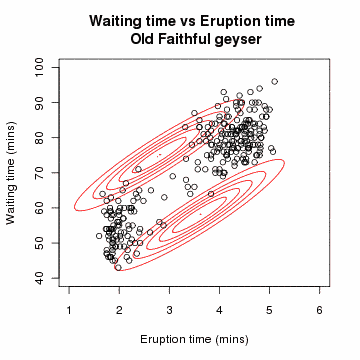
[[1](https://commons.wikimedia.org/wiki/File:Em_old_faithful.gif)]

## Variational Bayesian Gaussian Mixture (BGMM)

The `BayesianGaussianMixture` object
implements a variant of the Gaussian mixture model with variational
inference algorithms. The API is similar as the one defined by
`GaussianMixture`.

### Estimation algorithm: variational inference

Variational inference is an extension of expectation-maximization that
maximizes a lower bound on model evidence (including priors) instead of
data likelihood. The principle behind variational methods is the same as
expectation-maximization (that is both are iterative algorithms that
alternate between finding the probabilities for each point to be
generated by each mixture and fitting the mixture to these assigned
points), but variational methods add regularization by integrating
information from prior distributions. This avoids the singularities
often found in expectation-maximization solutions but introduces some
subtle biases to the model. Inference is often notably slower, but not
usually as much so as to render usage unpractical.

Due to its Bayesian nature, the variational algorithm needs more
hyper-parameters than expectation-maximization, the most important of
these being the concentration parameter `weight_concentration_prior`.
Specifying a low value for the concentration prior will make the model
put most of the weight on few components set the remaining components
weights very close to zero. High values of the concentration prior will
allow a larger number of components to be active in the mixture.

The parameters implementation of the
`BayesianGaussianMixture` class proposes
two types of prior for the weights distribution: a finite mixture model
with Dirichlet distribution and an infinite mixture model with the
Dirichlet Process. In practice Dirichlet Process inference algorithm is
approximated and uses a truncated distribution with a fixed maximum
number of components (called the Stick-breaking representation). The
number of components actually used almost always depends on the data.

The next figure compares the results obtained for the different type of
the weight concentration prior (parameter
`weight_concentration_prior_type`) for different values of
`weight_concentration_prior`. Here, we can see the value of the
`weight_concentration_prior` parameter has a strong impact on the
effective number of active components obtained. We can also notice that
large values for the concentration weight prior lead to more uniform
weights when the type of prior is `dirichlet_distribution` while this
is not necessarily the case for the `dirichlet_process` type (used by
default).

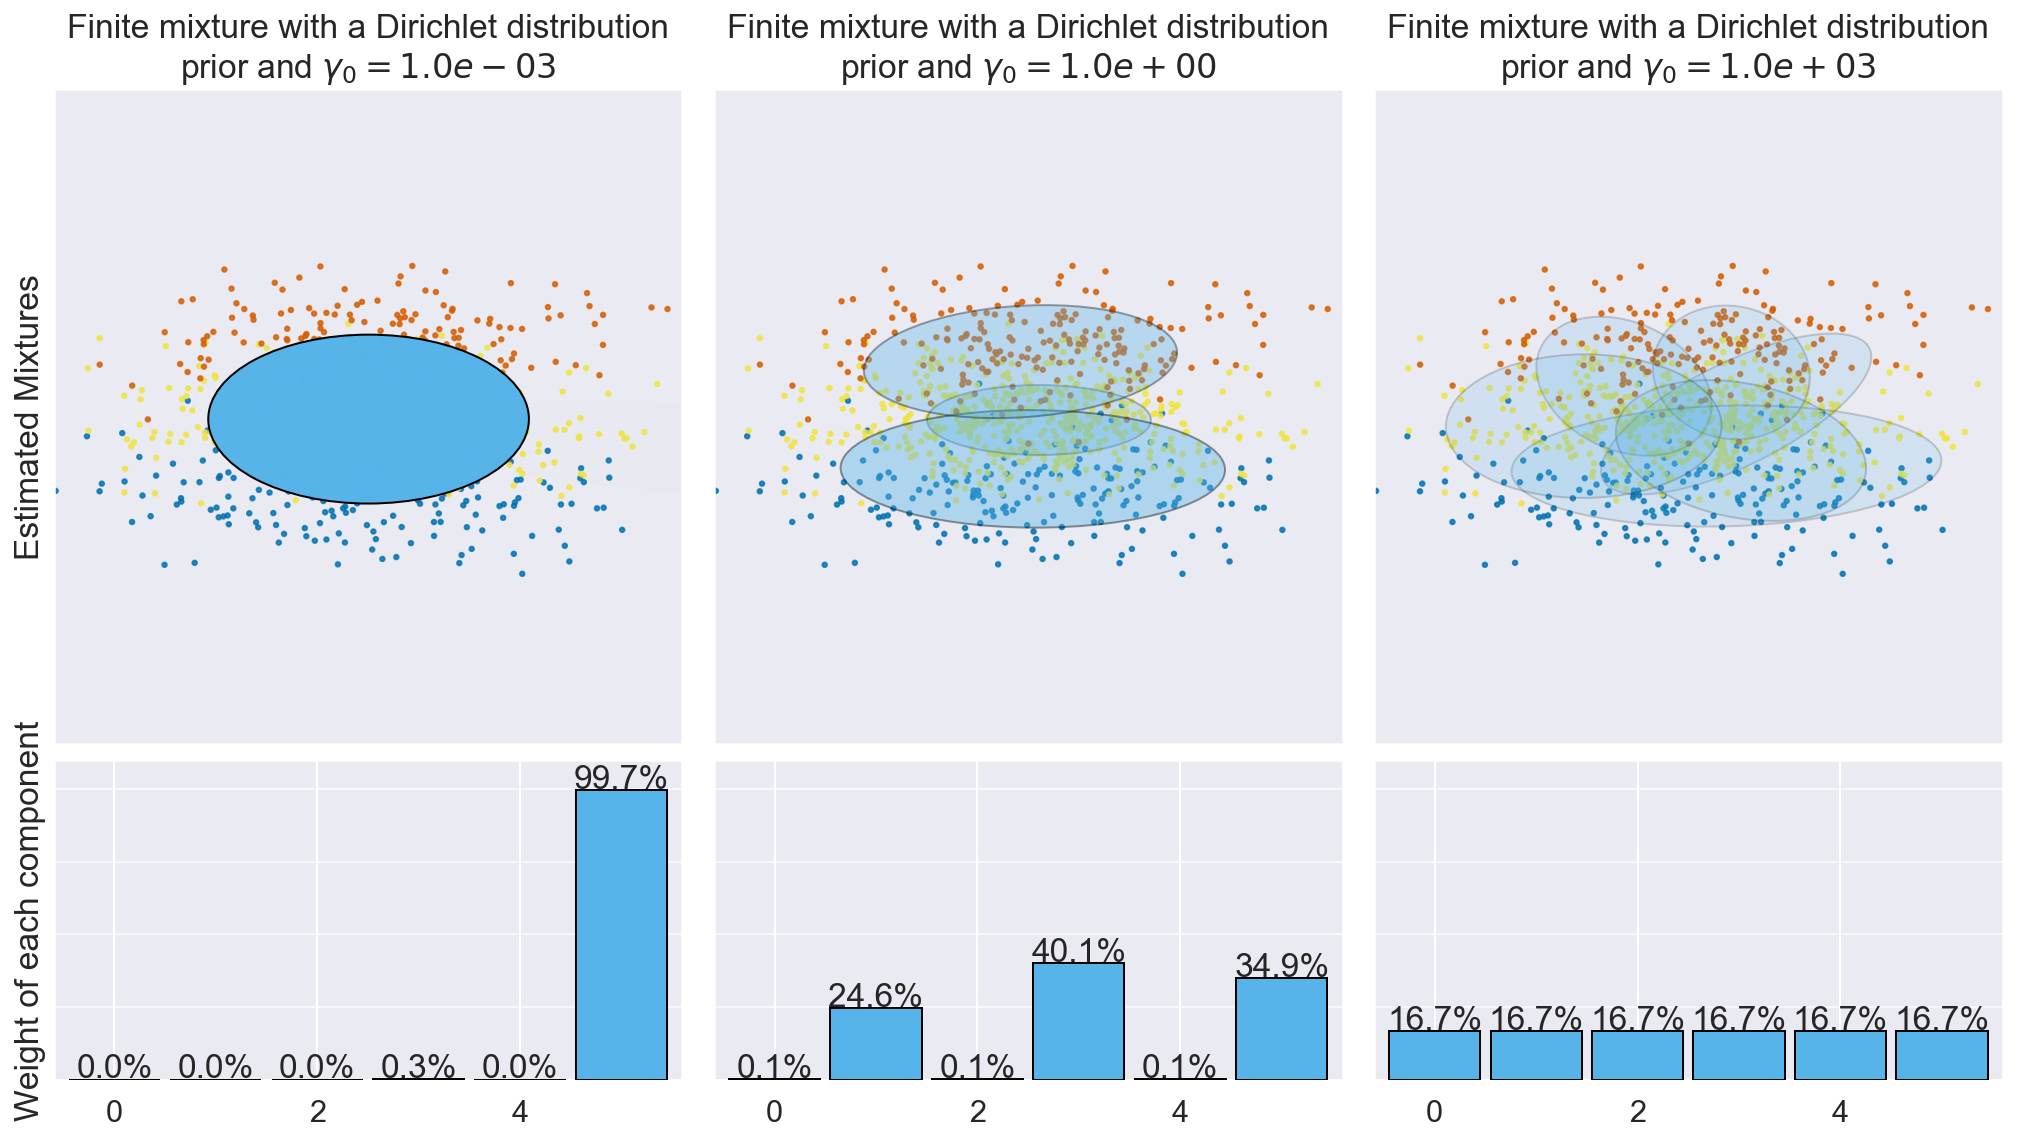

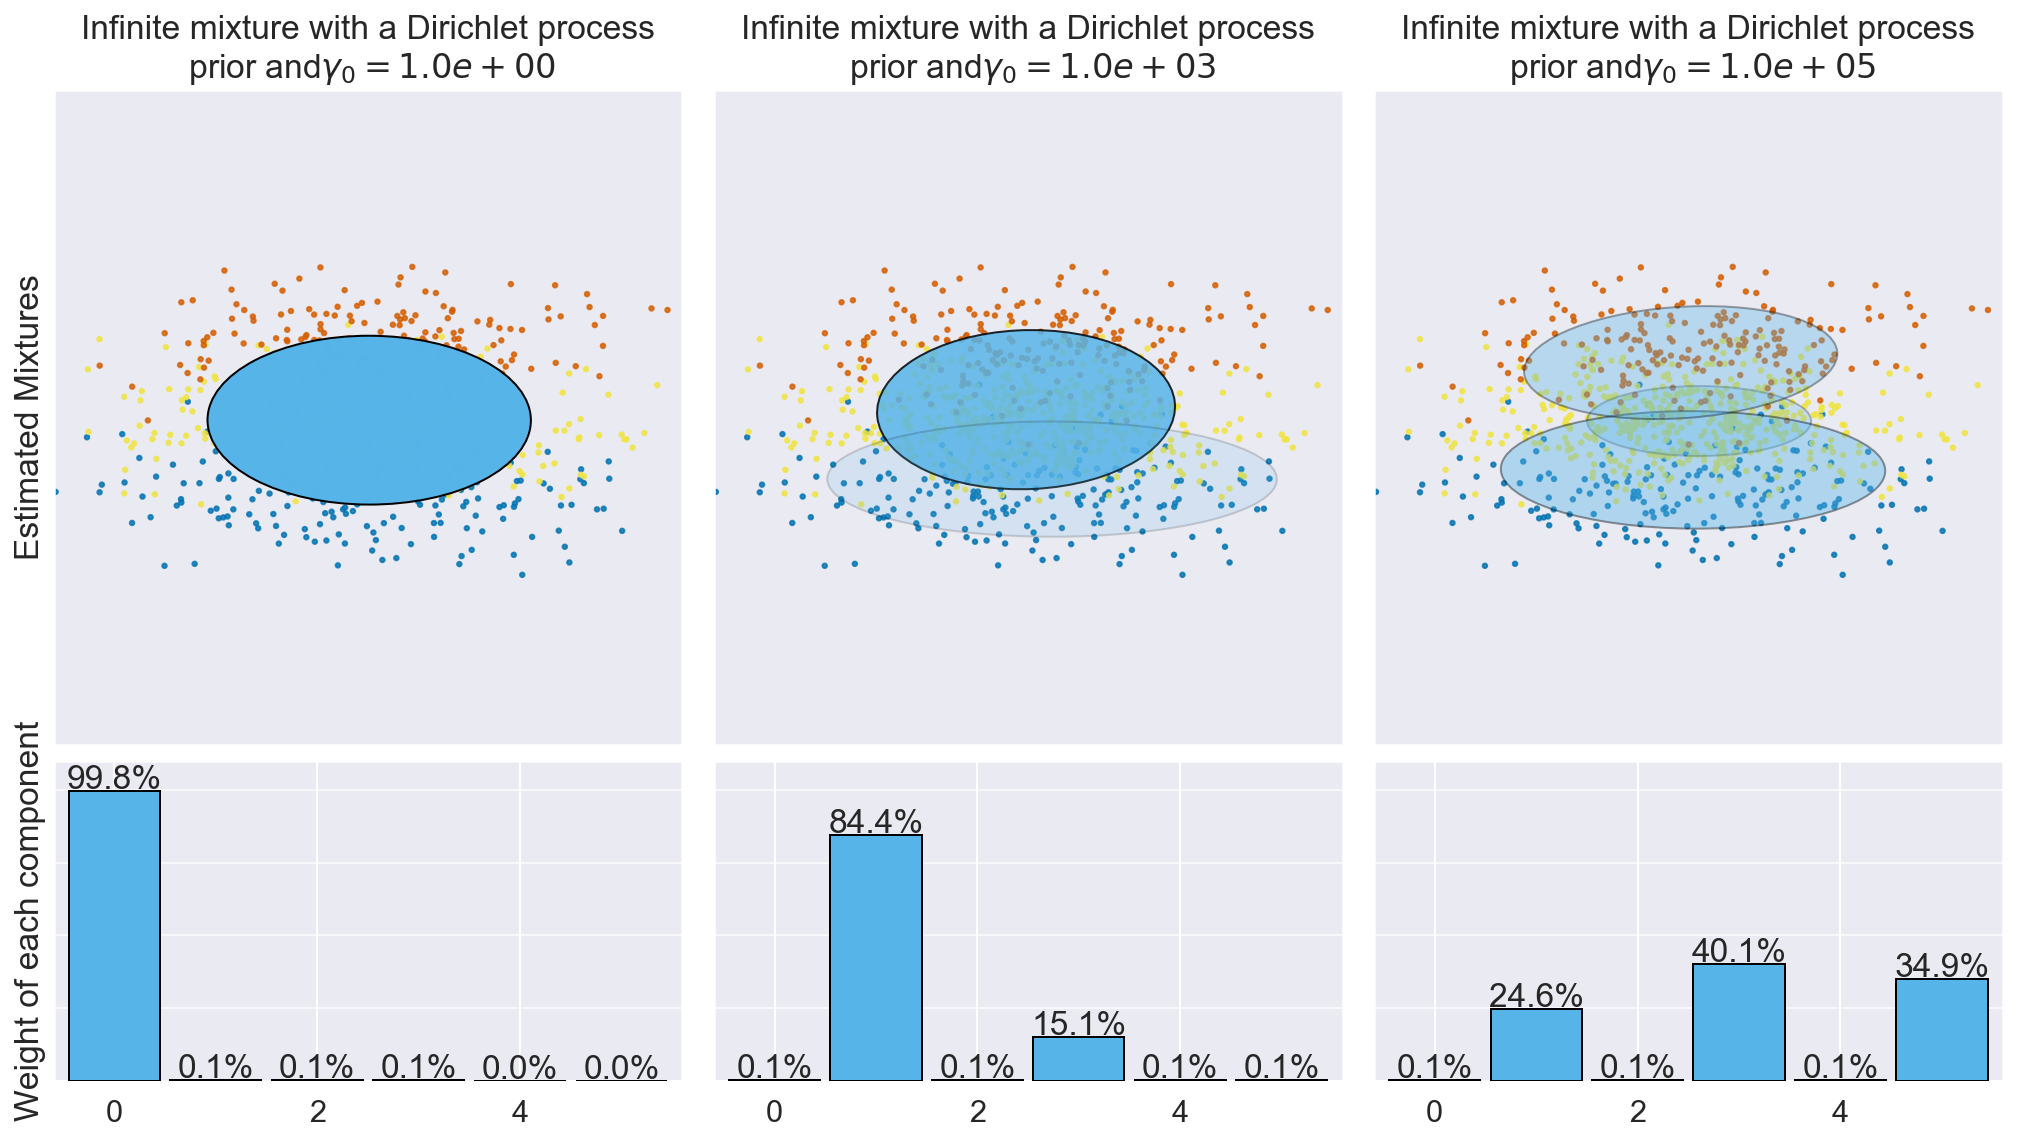

In [6]:
import matplotlib as mpl
import matplotlib.gridspec as gridspec

from sklearn.mixture import BayesianGaussianMixture

def plot_ellipses(ax, weights, means, covars):
    for n in range(means.shape[0]):
        eig_vals, eig_vecs = np.linalg.eigh(covars[n])
        unit_eig_vec = eig_vecs[0] / np.linalg.norm(eig_vecs[0])
        angle = np.arctan2(unit_eig_vec[1], unit_eig_vec[0])
        # Ellipse needs degrees
        angle = 180 * angle / np.pi
        # eigenvector normalization
        eig_vals = 2 * np.sqrt(2) * np.sqrt(eig_vals)
        ell = mpl.patches.Ellipse(means[n], eig_vals[0], eig_vals[1],
                                  180 + angle, edgecolor='black')
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(weights[n])
        ell.set_facecolor('#56B4E9')
        ax.add_artist(ell)


def plot_results(ax1, ax2, estimator, X, y, title, plot_title=False):
    ax1.set_title(title)
    ax1.scatter(X[:, 0], X[:, 1], s=5, marker='o', color=colors[y], alpha=0.8)
    ax1.set_xlim(-2., 2.)
    ax1.set_ylim(-3., 3.)
    ax1.set_xticks(())
    ax1.set_yticks(())
    plot_ellipses(ax1, estimator.weights_, estimator.means_,
                  estimator.covariances_)

    ax2.get_xaxis().set_tick_params(direction='out')
    ax2.yaxis.grid(True, alpha=0.7)
    for k, w in enumerate(estimator.weights_):
        ax2.bar(k, w, width=0.9, color='#56B4E9', zorder=3,
                align='center', edgecolor='black')
        ax2.text(k, w + 0.007, "%.1f%%" % (w * 100.),
                 horizontalalignment='center')
    ax2.set_xlim(-.6, 2 * n_components - .4)
    ax2.set_ylim(0., 1.1)
    ax2.tick_params(axis='y', which='both', left=False,
                    right=False, labelleft=False)
    ax2.tick_params(axis='x', which='both', top=False)

    if plot_title:
        ax1.set_ylabel('Estimated Mixtures')
        ax2.set_ylabel('Weight of each component')

# Parameters of the dataset
random_state, n_components, n_features = 2, 3, 2
colors = np.array(['#0072B2', '#F0E442', '#D55E00'])

covars = np.array([[[.7, .0], [.0, .1]],
                   [[.5, .0], [.0, .1]],
                   [[.5, .0], [.0, .1]]])
samples = np.array([200, 500, 200])
means = np.array([[.0, -.70],
                  [.0, .0],
                  [.0, .70]])

# mean_precision_prior= 0.8 to minimize the influence of the prior
estimators = [
    ("Finite mixture with a Dirichlet distribution\nprior and "
     r"$\gamma_0=$", BayesianGaussianMixture(
        weight_concentration_prior_type="dirichlet_distribution",
        n_components=2 * n_components, reg_covar=0, init_params='random',
        max_iter=1500, mean_precision_prior=.8,
        random_state=random_state), [0.001, 1, 1000]),
    ("Infinite mixture with a Dirichlet process\n prior and" r"$\gamma_0=$",
     BayesianGaussianMixture(
        weight_concentration_prior_type="dirichlet_process",
        n_components=2 * n_components, reg_covar=0, init_params='random',
        max_iter=1500, mean_precision_prior=.8,
        random_state=random_state), [1, 1000, 100000])]

# Generate data
rng = np.random.RandomState(random_state)
X = np.vstack([
    rng.multivariate_normal(means[j], covars[j], samples[j])
    for j in range(n_components)])
y = np.concatenate([np.full(samples[j], j, dtype=int)
                    for j in range(n_components)])

# Plot results in two different figures
for (title, estimator, concentrations_prior) in estimators:
    plt.figure(figsize=(4.7 * 3, 8))
    plt.subplots_adjust(bottom=.04, top=0.90, hspace=.05, wspace=.05,
                        left=.03, right=.99)

    gs = gridspec.GridSpec(3, len(concentrations_prior))
    for k, concentration in enumerate(concentrations_prior):
        estimator.weight_concentration_prior = concentration
        estimator.fit(X)
        plot_results(plt.subplot(gs[0:2, k]), plt.subplot(gs[2, k]), estimator,
                     X, y, r"%s$%.1e$" % (title, concentration),
                     plot_title=k == 0)

plt.show()

The examples below compare Gaussian mixture models with a fixed number
of components, to the variational Gaussian mixture models with a
Dirichlet process prior. Here, a classical Gaussian mixture is fitted
with 5 components on a dataset composed of 2 clusters. We can see that
the variational Gaussian mixture with a Dirichlet process prior is able
to limit itself to only 2 components whereas the Gaussian mixture fits
the data with a fixed number of components that has to be set a priori
by the user. In this case the user has selected `n_components=5` which
does not match the true generative distribution of this toy dataset.
Note that with very little observations, the variational Gaussian
mixture models with a Dirichlet process prior can take a conservative
stand, and fit only one component.

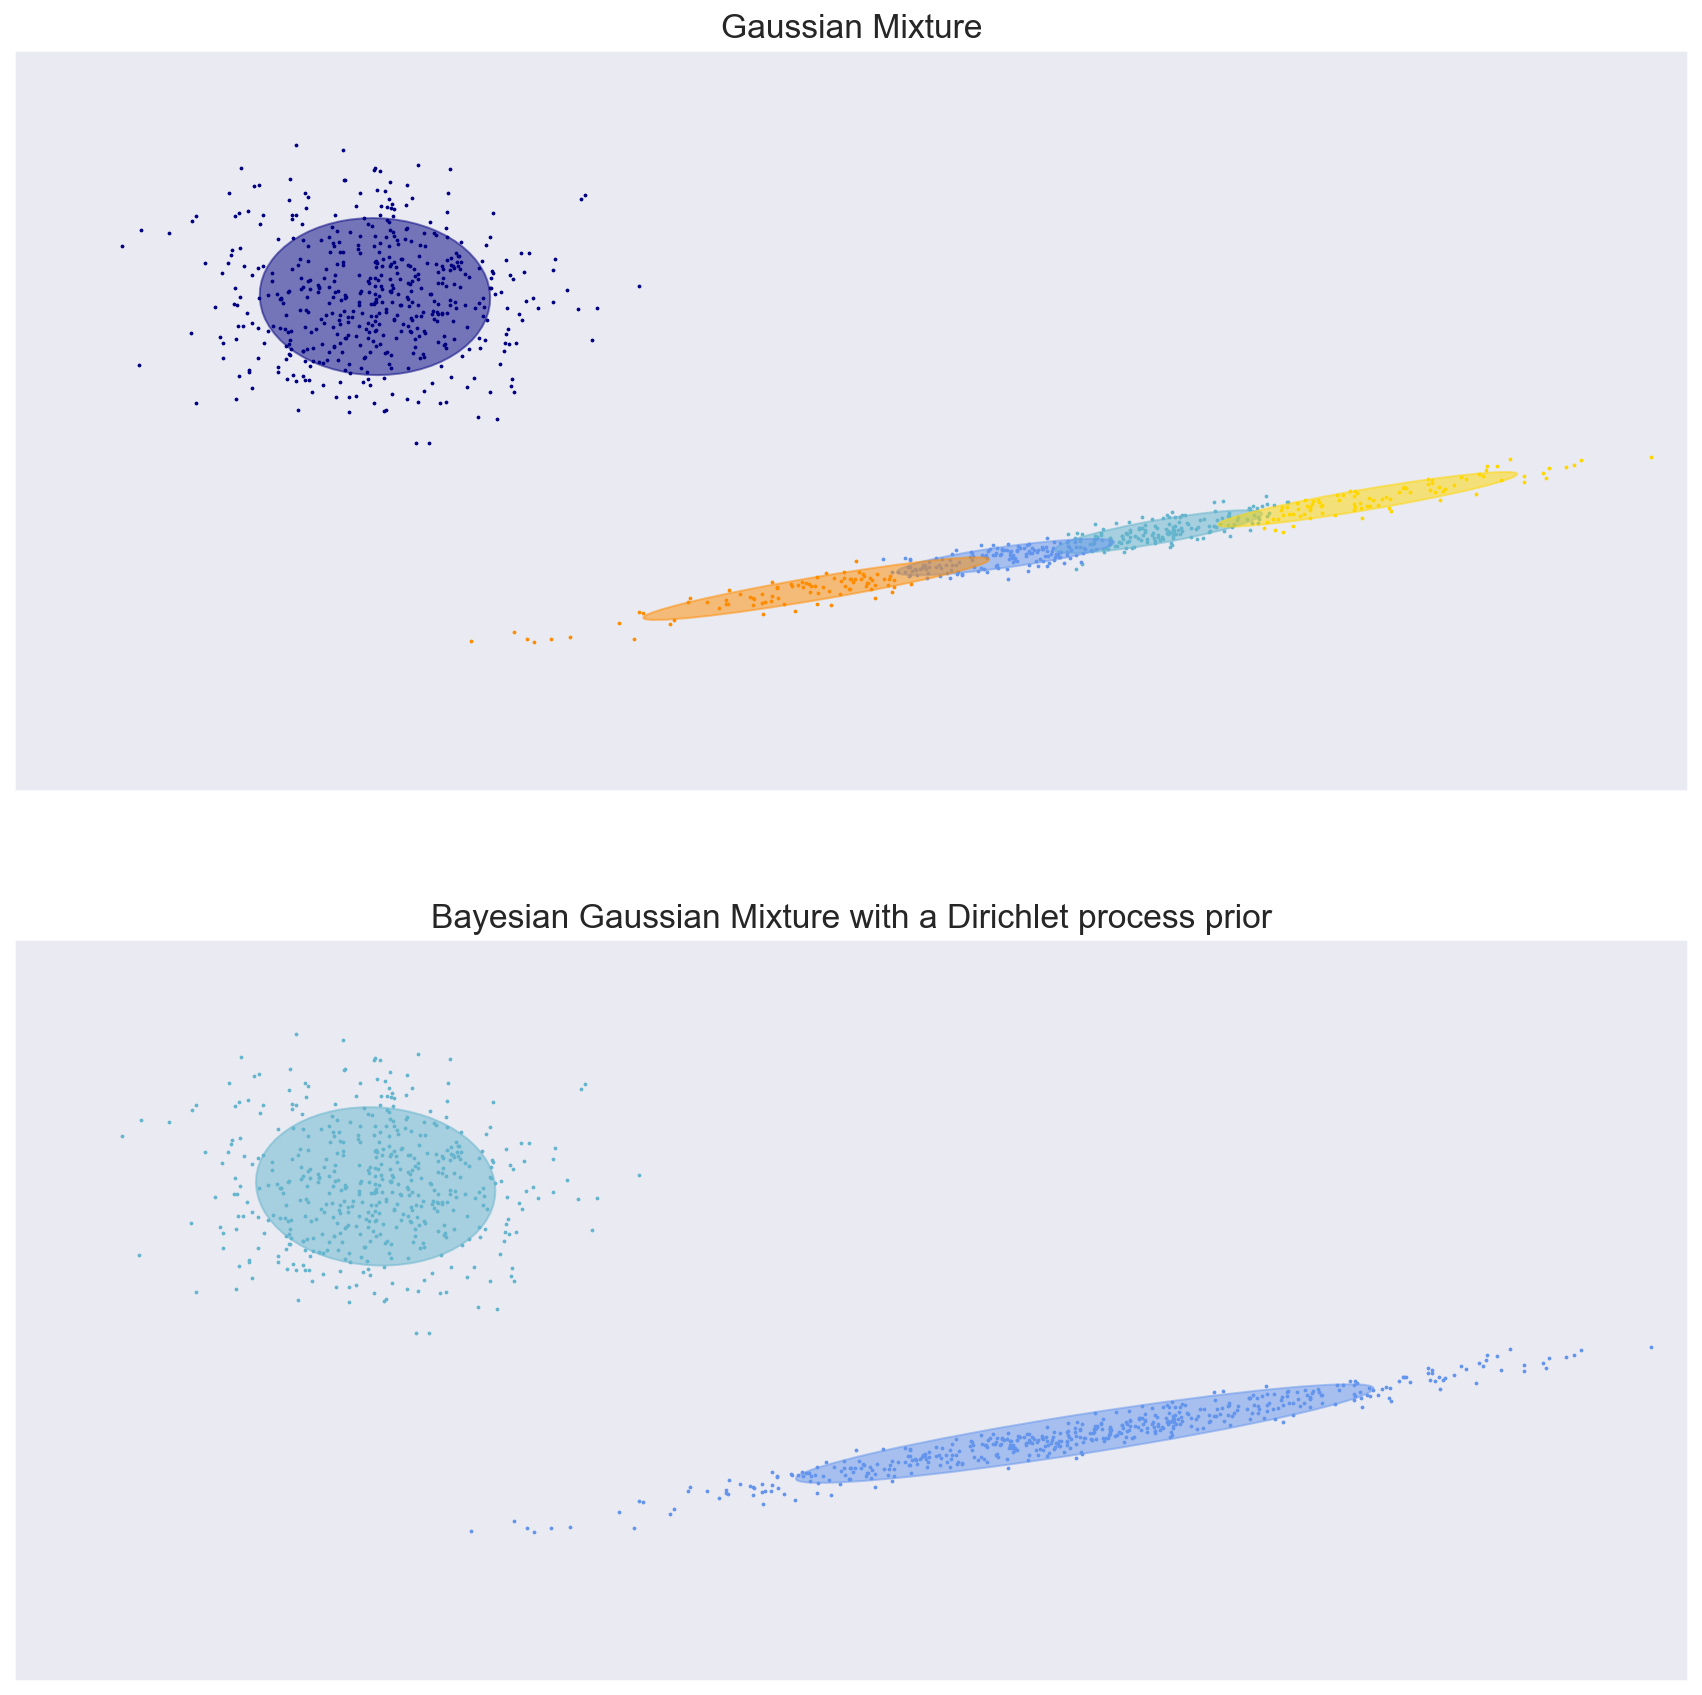

In [7]:
import itertools
from scipy import linalg
import matplotlib as mpl

from sklearn import mixture

color_iter = itertools.cycle(['navy', 'c', 'cornflowerblue', 'gold',
                              'darkorange'])


def plot_results(X, Y_, means, covariances, index, title):
    splot = plt.subplot(2, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    plt.xlim(-9., 5.)
    plt.ylim(-3., 6.)
    plt.xticks(())
    plt.yticks(())
    plt.title(title)


# Number of samples per component
n_samples = 500

# Generate random sample, two components
np.random.seed(0)
C = np.array([[0., -0.1], [1.7, .4]])
X = np.r_[np.dot(np.random.randn(n_samples, 2), C),
          .7 * np.random.randn(n_samples, 2) + np.array([-6, 3])]

# Fit a Gaussian mixture with EM using five components
gmm = mixture.GaussianMixture(n_components=5, covariance_type='full').fit(X)
plt.figure(figsize=(15, 15))
plot_results(X, gmm.predict(X), gmm.means_, gmm.covariances_, 0,
             'Gaussian Mixture')

# Fit a Dirichlet process Gaussian mixture using five components
dpgmm = mixture.BayesianGaussianMixture(n_components=5,
                                        covariance_type='full').fit(X)
plot_results(X, dpgmm.predict(X), dpgmm.means_, dpgmm.covariances_, 1,
             'Bayesian Gaussian Mixture with a Dirichlet process prior')

plt.show()

On the following figure we are fitting a dataset not well-depicted by a
Gaussian mixture. Adjusting the `weight_concentration_prior`, parameter
of the `BayesianGaussianMixture`
controls the number of components used to fit this data. We also present
on the last two plots a random sampling generated from the two resulting
mixtures.

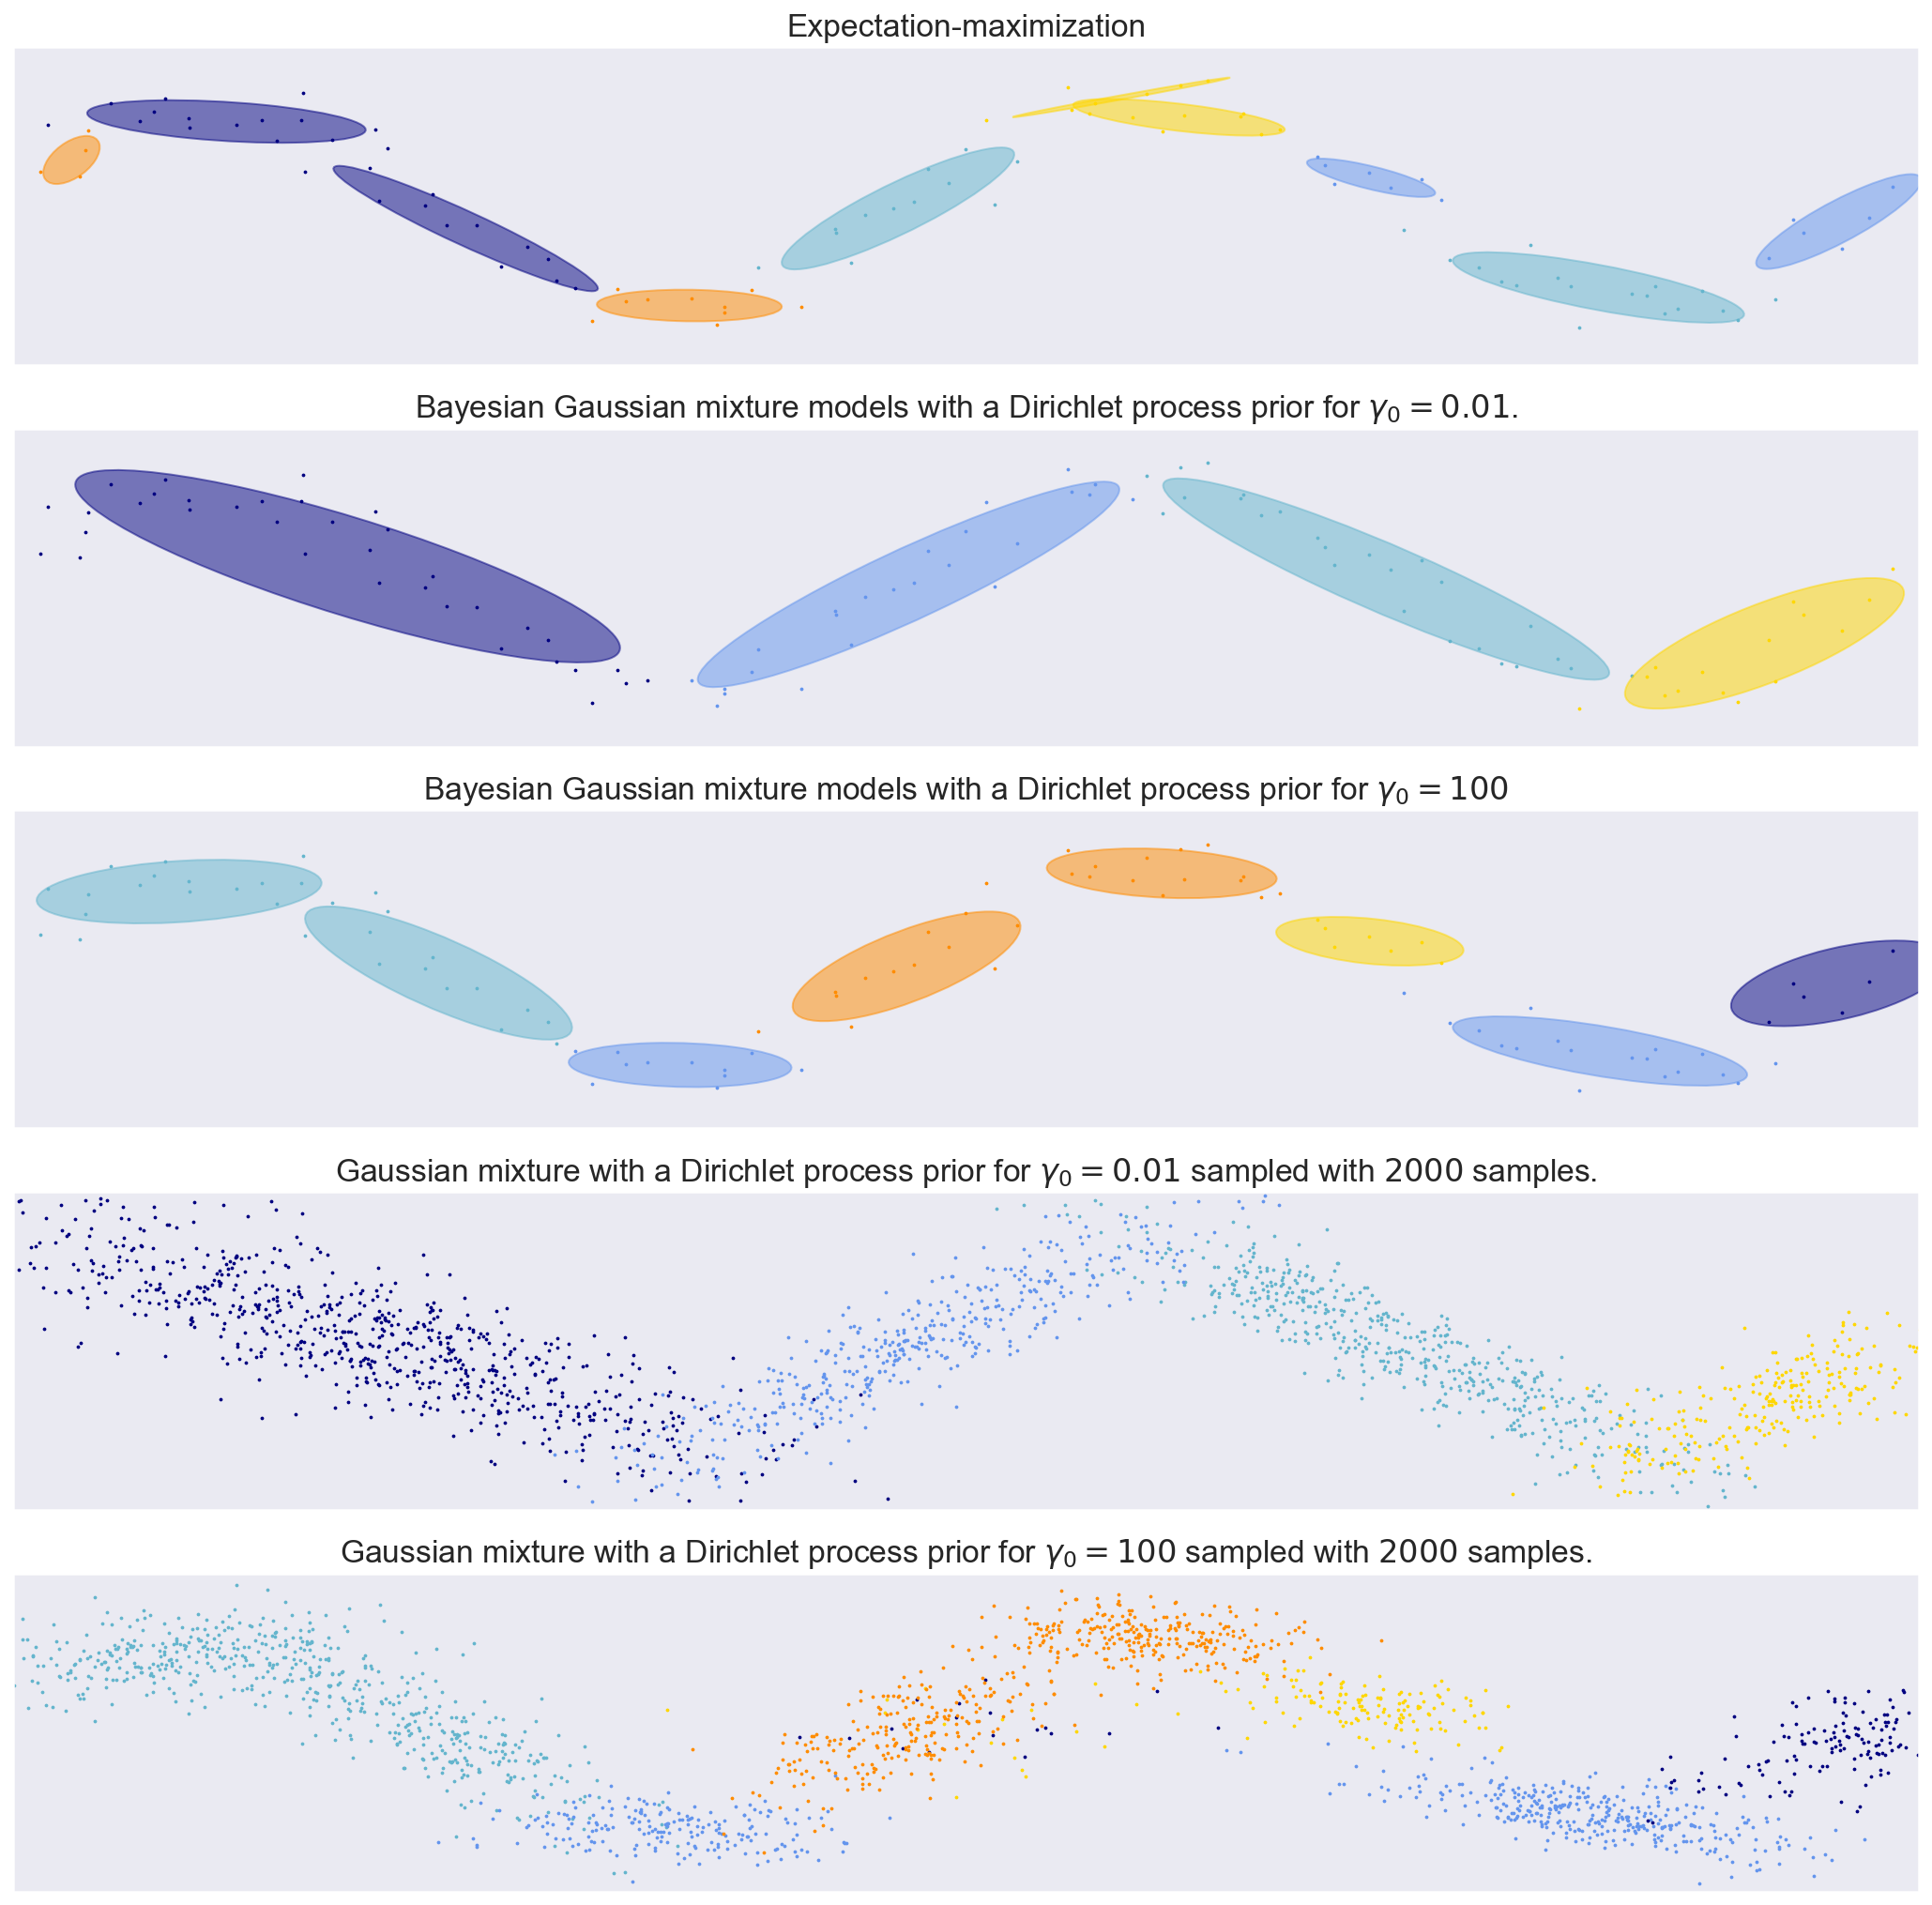

In [8]:
# Gaussian Mixture Model Sine Curve

import itertools
from scipy import linalg
import matplotlib as mpl
from sklearn import mixture

color_iter = itertools.cycle(['navy', 'c', 'cornflowerblue', 'gold',
                              'darkorange'])


def plot_results(X, Y, means, covariances, index, title):
    splot = plt.subplot(5, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y == i):
            continue
        plt.scatter(X[Y == i, 0], X[Y == i, 1], .8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    plt.xlim(-6., 4. * np.pi - 6.)
    plt.ylim(-5., 5.)
    plt.title(title)
    plt.xticks(())
    plt.yticks(())


def plot_samples(X, Y, n_components, index, title):
    plt.subplot(5, 1, 4 + index)
    for i, color in zip(range(n_components), color_iter):
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y == i):
            continue
        plt.scatter(X[Y == i, 0], X[Y == i, 1], .8, color=color)

    plt.xlim(-6., 4. * np.pi - 6.)
    plt.ylim(-5., 5.)
    plt.title(title)
    plt.xticks(())
    plt.yticks(())


# Parameters
n_samples = 100

# Generate random sample following a sine curve
np.random.seed(0)
X = np.zeros((n_samples, 2))
step = 4. * np.pi / n_samples

for i in range(X.shape[0]):
    x = i * step - 6.
    X[i, 0] = x + np.random.normal(0, 0.1)
    X[i, 1] = 3. * (np.sin(x) + np.random.normal(0, .2))

plt.figure(figsize=(15, 15))
plt.subplots_adjust(bottom=.04, top=0.95, hspace=.2, wspace=.05,
                    left=.03, right=.97)

# Fit a Gaussian mixture with EM using ten components
gmm = mixture.GaussianMixture(n_components=10, covariance_type='full',
                              max_iter=100).fit(X)
plot_results(X, gmm.predict(X), gmm.means_, gmm.covariances_, 0,
             'Expectation-maximization')

dpgmm = mixture.BayesianGaussianMixture(
    n_components=10, covariance_type='full', weight_concentration_prior=1e-2,
    weight_concentration_prior_type='dirichlet_process',
    mean_precision_prior=1e-2, covariance_prior=1e0 * np.eye(2),
    init_params="random", max_iter=100, random_state=2).fit(X)
plot_results(X, dpgmm.predict(X), dpgmm.means_, dpgmm.covariances_, 1,
             "Bayesian Gaussian mixture models with a Dirichlet process prior "
             r"for $\gamma_0=0.01$.")

X_s, y_s = dpgmm.sample(n_samples=2000)
plot_samples(X_s, y_s, dpgmm.n_components, 0,
             "Gaussian mixture with a Dirichlet process prior "
             r"for $\gamma_0=0.01$ sampled with $2000$ samples.")

dpgmm = mixture.BayesianGaussianMixture(
    n_components=10, covariance_type='full', weight_concentration_prior=1e+2,
    weight_concentration_prior_type='dirichlet_process',
    mean_precision_prior=1e-2, covariance_prior=1e0 * np.eye(2),
    init_params="kmeans", max_iter=100, random_state=2).fit(X)
plot_results(X, dpgmm.predict(X), dpgmm.means_, dpgmm.covariances_, 2,
             "Bayesian Gaussian mixture models with a Dirichlet process prior "
             r"for $\gamma_0=100$")

X_s, y_s = dpgmm.sample(n_samples=2000)
plot_samples(X_s, y_s, dpgmm.n_components, 1,
             "Gaussian mixture with a Dirichlet process prior "
             r"for $\gamma_0=100$ sampled with $2000$ samples.")

plt.show()

`BayesianGaussianMixture` model:

**Advantages**
* *Automatic selection* : when `weight_concentration_prior` is small enough and `n_components` is larger than what is found necessary by the model, the Variational Bayesian mixture model has a natural tendency to set some mixture weights values close to zero. This makes it possible to let the model choose a suitable number of effective components automatically. Only an upper bound of this number needs to be provided. Note however that the "ideal" number of active components is very application specific and is typically ill-defined in a data exploration setting.
* *Less sensitivity to the number of parameters* : unlike finite models, which will almost always use all components as much as they can, and hence will produce wildly different solutions for different numbers of components, the variational inference with a Dirichlet process prior (`weight_concentration_prior_type='dirichlet_process'`) won't change much with changes to the parameters, leading to more stability and less tuning.
* *Regularization* : due to the incorporation of prior information, variational solutions have less pathological special cases than expectation-maximization solutions.

**Disadvantages**
* *Speed* : the extra parametrization necessary for variational inference make inference slower, although not by much.
* *Hyperparameters* : this algorithm needs an extra hyperparameter that might need experimental tuning via cross-validation.
* *Bias* : there are many implicit biases in the inference algorithms (and also in the Dirichlet process if used), and whenever there is a mismatch between these biases and the data it might be possible to fit better models using a finite mixture.

#### The Dirichlet Process

Here we describe variational inference algorithms on Dirichlet process
mixture. The Dirichlet process is a prior probability distribution on
*clusterings with an infinite, unbounded, number of partitions*.
Variational techniques let us incorporate this prior structure on
Gaussian mixture models at almost no penalty in inference time,
comparing with a finite Gaussian mixture model.

An important question is how can the Dirichlet process use an infinite,
unbounded number of clusters and still be consistent. While a full
explanation doesn\'t fit this manual, one can think of its [stick
breaking process](https://en.wikipedia.org/wiki/Dirichlet_process#The_stick-breaking_process)
analogy to help understanding it. The stick breaking process is a
generative story for the Dirichlet process. We start with a unit-length
stick and in each step we break off a portion of the remaining stick.
Each time, we associate the length of the piece of the stick to the
proportion of points that falls into a group of the mixture. At the end,
to represent the infinite mixture, we associate the last remaining piece
of the stick to the proportion of points that don't fall into all the
other groups. The length of each piece is a random variable with
probability proportional to the concentration parameter. Smaller value
of the concentration will divide the unit-length into larger pieces of
the stick (defining more concentrated distribution). Larger
concentration values will create smaller pieces of the stick (increasing
the number of components with non zero weights).

Variational inference techniques for the Dirichlet process still work
with a finite approximation to this infinite mixture model, but instead
of having to specify a priori how many components one wants to use, one
just specifies the concentration parameter and an upper bound on the
number of mixture components (this upper bound, assuming it is higher
than the "true" number of components, affects only algorithmic
complexity, not the actual number of components used).

[[2](https://scikit-learn.org/stable/modules/mixture.html)]